Finetune the BERT on the 3 data variations:
- Original data: Fine-tune using original_train.csv.
- Neutral data: Fine-tune using neutral_train.csv.
- Balanced (mix) data: Fine-tune using mix_train.csv.

In the end, I'll have 3 finetuned models
- One trained on the original data
- One trained on the neutral data
- One trained on the balanced (mix) data


...

After finetuning, the next step is to test each of these models.

In [ ]:
#pip install torch pandas numpy scikit-learn transformers tqdm deep_translator seaborn matplot optuna

In [1]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from torch.optim import lr_scheduler
import torch.nn as nn

from transformers import AdamW, get_linear_schedule_with_warmup, get_scheduler
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForTokenClassification, AutoModelForSequenceClassification

from collections import Counter
from tqdm import tqdm

from deep_translator import GoogleTranslator

import seaborn as sns
import matplotlib.pyplot as plt

import optuna

In [20]:
# tuning test

# https://www.geeksforgeeks.org/hyperparameter-tuning-with-optuna-in-pytorch/

def objective(trial):

    # Hyperparameters to tune
    dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [8, 16])
    num_epochs = trial.suggest_int('epochs', 2, 15)
    lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
    warmup = trial.suggest_categorical('warmup', [0.0, 0.1])

    # load data
    train_file = "/work/SofieNørboMosegaard#5741/NLP/NLP-exam/data_2/original_train.csv"
    train_text, train_labels = load_data(train_file)

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained("vesteinn/DanskBERT")

    # Model
    model = AutoModelForSequenceClassification.from_pretrained("vesteinn/DanskBERT", num_labels = 2)
    model.classifier = nn.Sequential(nn.Dropout(dropout_rate), model.classifier)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize and prepare data
    input_ids, attention_masks, labels = tokenize_data(train_text, train_labels, tokenizer)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    train_dataset, val_dataset = train_test_split(dataset, test_size = 0.3, stratify = labels)

    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    validation_dataloader = DataLoader(val_dataset, batch_size = batch_size)

    # Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr = lr, eps = 1e-8, weight_decay = 0.01)
    total_steps = len(train_dataloader) * num_epochs
    num_warmup_steps = int(warmup * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = total_steps)


    # Training Loop

    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1} / {num_epochs}")

        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_dataloader, desc = "Training"):
            
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            optimizer.zero_grad()

            result = model(b_input_ids, attention_mask = b_input_mask, labels = b_labels)
            loss = result.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        # Validation
        print("Running Validation...")
        model.eval()
        total_val_loss = 0

        for batch in tqdm(validation_dataloader, desc = "Validation"):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                result = model(b_input_ids, attention_mask = b_input_mask, labels = b_labels)
                loss = result.loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(validation_dataloader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

        trial.report(avg_val_loss, epoch)

        # suggest whether to end the current hyperparameter trail (works like early stopping)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    save_trial_results(trial.number, trial.params, best_val_loss)
    return best_val_loss


In [22]:
def save_trial_results(trial_number, params, best_val_loss):
    result_dict = {
        'trial': trial_number,
        'params': params,
        'best_val_loss': best_val_loss
    }
        df = pd.DataFrame([result_dict])    
    results_path = '/work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuning-testing/optuna_results.csv'    
    file_exists = os.path.exists(results_path)    
    df.to_csv(results_path, mode = 'a', header = not file_exists, index = False)

In [26]:
study.best_params

{'lr': 0.0006581424035306149,
 'batch_size': 16,
 'dropout': 0.3689728570516613,
 'epochs': 14}

In [23]:
if __name__ == "__main__":

    study = optuna.create_study(direction = "minimize")
    study.optimize(objective, n_trials = 10)

    print("Best Hyperparameters:", study.best_params)

# Best Hyperparameters: {'lr': 0.0006581424035306149, 'batch_size': 16, 'dropout': 0.3689728570516613, 'epochs': 14}


[I 2024-12-12 17:24:33,276] A new study created in memory with name: no-name-1d88b35f-38e2-4fc2-919d-5dd42c592b69
/tmp/ipykernel_1141/3057807505.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
/tmp/ipykernel_1141/3057807505.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-str

Epoch 1 / 4


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:08<00:00,  4.35it/s]


Epoch 2 / 4




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.40it/s]


Epoch 3 / 4


Training:   0%|          | 0/84 [01:03<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:08<00:00,  4.43it/s]


Epoch 4 / 4




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Training:   0%|          | 0/84 [01:02<?, ?it/s]
[I 2024-12-12 17:28:50,929] Trial 0 finished with value: 0.7901819932352131 and parameters: {'lr': 5.370580355939327e-05, 'batch_size': 16, 'dropout': 0.10302326290599534, 'epochs': 4}. Best is trial 0 with value: 0.7901819932352131.
/tmp/ipykernel_1141/3057807505.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
/tmp/ipykernel_1141/3057807505.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and are newly initi

Epoch 1 / 9


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 2 / 9




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 3 / 9


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 4 / 9




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 5 / 9


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 6 / 9




Training:   0%|          | 0/84 [01:01<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 7 / 9


Training:   0%|          | 0/84 [01:01<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.55it/s]


Epoch 8 / 9




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 9 / 9


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Training:   0%|          | 0/84 [01:02<?, ?it/s]
[I 2024-12-12 17:38:15,201] Trial 1 finished with value: 0.6929023067156473 and parameters: {'lr': 0.0006994386157775719, 'batch_size': 16, 'dropout': 0.31266448063744356, 'epochs': 9}. Best is trial 1 with value: 0.6929023067156473.
/tmp/ipykernel_1141/3057807505.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
/tmp/ipykernel_1141/3057807505.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
Some weights of XLMRobertaForSequenceClassification were not initi

Epoch 1 / 5


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:08<00:00,  4.41it/s]


Epoch 2 / 5




Training:   0%|          | 0/84 [01:03<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.49it/s]


Epoch 3 / 5


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 4 / 5




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 5 / 5


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Training:   0%|          | 0/84 [01:02<?, ?it/s]
[I 2024-12-12 17:43:33,556] Trial 2 finished with value: 0.6927278290192286 and parameters: {'lr': 0.00010071486029848248, 'batch_size': 16, 'dropout': 0.48037121372492175, 'epochs': 5}. Best is trial 2 with value: 0.6927278290192286.
/tmp/ipykernel_1141/3057807505.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
/tmp/ipykernel_1141/3057807505.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
Some weights of XLMRobertaForSequenceClassification were not init

Epoch 1 / 7


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.61it/s]


Epoch 2 / 7




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 3 / 7


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 4 / 7




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 5 / 7


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 6 / 7




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 7 / 7


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Training:   0%|          | 0/84 [01:02<?, ?it/s]
[I 2024-12-12 17:50:54,790] Trial 3 finished with value: 0.6929283125532998 and parameters: {'lr': 0.0004913822980305701, 'batch_size': 16, 'dropout': 0.32791007747507095, 'epochs': 7}. Best is trial 2 with value: 0.6927278290192286.
/tmp/ipykernel_1141/3057807505.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
/tmp/ipykernel_1141/3057807505.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
Some weights of XLMRobertaForSequenceClassification were not initi

Epoch 1 / 4


Running Validation...


















































































































































Validation: 100%|██████████| 72/72 [00:07<00:00,  9.27it/s]


Epoch 2 / 4




Training:   0%|          | 0/167 [01:03<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 72/72 [00:07<00:00,  9.29it/s]


Epoch 3 / 4


Training:   0%|          | 0/167 [01:03<?, ?it/s]


Running Validation...


















































































































































Validation: 100%|██████████| 72/72 [00:07<00:00,  9.31it/s]


Epoch 4 / 4




Training:   0%|          | 0/167 [01:03<?, ?it/s]


Running Validation...


Training:   0%|          | 0/167 [01:03<?, ?it/s]
[I 2024-12-12 17:55:11,311] Trial 4 finished with value: 0.69268206672536 and parameters: {'lr': 8.630135246370217e-05, 'batch_size': 8, 'dropout': 0.1526985453399027, 'epochs': 4}. Best is trial 4 with value: 0.69268206672536.
/tmp/ipykernel_1141/3057807505.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
/tmp/ipykernel_1141/3057807505.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and are newly initialize

Epoch 1 / 14


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 2 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s]


Epoch 3 / 14


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.62it/s]


Epoch 4 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.62it/s]


Epoch 5 / 14


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.61it/s]


Epoch 6 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s]


Epoch 7 / 14


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s]


Epoch 8 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s]


Epoch 9 / 14


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s]


Epoch 10 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s]


Epoch 11 / 14


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s]


Epoch 12 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s]


Epoch 13 / 14


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s]


Epoch 14 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Training:   0%|          | 0/84 [01:02<?, ?it/s]
[I 2024-12-12 18:09:50,949] Trial 5 finished with value: 0.6925964388582442 and parameters: {'lr': 0.0006581424035306149, 'batch_size': 16, 'dropout': 0.3689728570516613, 'epochs': 14}. Best is trial 5 with value: 0.6925964388582442.
/tmp/ipykernel_1141/3057807505.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
/tmp/ipykernel_1141/3057807505.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and are newly initi

Epoch 1 / 14


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:08<00:00,  4.47it/s]


Epoch 2 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 3 / 14


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.56it/s]


Epoch 4 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.58it/s]


Epoch 5 / 14


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.59it/s]


Epoch 6 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 7 / 14


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 8 / 14




Training:   0%|          | 0/84 [01:01<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 9 / 14


Training:   0%|          | 0/84 [01:01<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.61it/s]


Epoch 10 / 14




Training:   0%|          | 0/84 [01:01<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.61it/s]


Epoch 11 / 14


Training:   0%|          | 0/84 [01:01<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.60it/s]


Epoch 12 / 14




Training:   0%|          | 0/84 [01:01<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.62it/s]


Epoch 13 / 14


Training:   0%|          | 0/84 [01:01<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.55it/s]


Epoch 14 / 14




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.55it/s]
[I 2024-12-12 18:24:26,007] Trial 6 pruned. 
/tmp/ipykernel_1141/3057807505.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
/tmp/ipykernel_1141/3057807505.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
Training:   0%|          | 0/84 [01:03<?, ?it/s]
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should

Epoch 1 / 5


Running Validation...


















































































































































Validation: 100%|██████████| 72/72 [00:07<00:00,  9.19it/s]


Epoch 2 / 5




Training:   0%|          | 0/167 [01:03<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 72/72 [00:07<00:00,  9.25it/s]


Epoch 3 / 5


Training:   0%|          | 0/167 [01:03<?, ?it/s]


Running Validation...


















































































































































Validation: 100%|██████████| 72/72 [00:07<00:00,  9.26it/s]


Epoch 4 / 5




Training:   0%|          | 0/167 [01:03<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 72/72 [00:07<00:00,  9.32it/s]


Epoch 5 / 5


Training:   0%|          | 0/167 [01:03<?, ?it/s]


Running Validation...


















































































































































Validation: 100%|██████████| 72/72 [00:07<00:00,  9.31it/s]
[I 2024-12-12 18:29:46,783] Trial 7 pruned. 
/tmp/ipykernel_1141/3057807505.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
/tmp/ipykernel_1141/3057807505.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
Training:   0%|          | 0/167 [01:03<?, ?it/s]
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and

Epoch 1 / 4


Running Validation...


















































































































































Validation: 100%|██████████| 72/72 [00:07<00:00,  9.26it/s]


Epoch 2 / 4




Training:   0%|          | 0/167 [01:03<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 72/72 [00:07<00:00,  9.30it/s]


Epoch 3 / 4


Training:   0%|          | 0/167 [01:03<?, ?it/s]


Running Validation...


















































































































































Validation: 100%|██████████| 72/72 [00:07<00:00,  9.35it/s]


Epoch 4 / 4




Training:   0%|          | 0/167 [01:03<?, ?it/s]


Running Validation...


Training:   0%|          | 0/167 [01:03<?, ?it/s]
[I 2024-12-12 18:34:02,932] Trial 8 finished with value: 0.6928701624274254 and parameters: {'lr': 0.0002550854929593458, 'batch_size': 8, 'dropout': 0.42183283195367594, 'epochs': 4}. Best is trial 5 with value: 0.6925964388582442.
/tmp/ipykernel_1141/3057807505.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 5e-5, 1e-3)
/tmp/ipykernel_1141/3057807505.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and are newly initi

Epoch 1 / 12


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:08<00:00,  4.47it/s]


Epoch 2 / 12




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.49it/s]


Epoch 3 / 12


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 4 / 12




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 5 / 12


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 6 / 12




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.54it/s]


Epoch 7 / 12


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 8 / 12




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 9 / 12


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 10 / 12




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Validation: 100%|██████████| 36/36 [00:07<00:00,  4.52it/s]


Epoch 11 / 12


Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...












































































Validation: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


Epoch 12 / 12




Training:   0%|          | 0/84 [01:02<?, ?it/s]


Running Validation...


Training:   0%|          | 0/84 [01:02<?, ?it/s]
[I 2024-12-12 18:46:39,024] Trial 9 finished with value: 0.692803916003969 and parameters: {'lr': 0.0007669664714066482, 'batch_size': 16, 'dropout': 0.39372373567723373, 'epochs': 12}. Best is trial 5 with value: 0.6925964388582442.


Best Hyperparameters: {'lr': 0.0006581424035306149, 'batch_size': 16, 'dropout': 0.3689728570516613, 'epochs': 14}


In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Function to compute the accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(preds_flat == labels_flat) / len(labels_flat)

In [4]:
# Function to calculate F1, recall, and precision

def compute_metrics(preds, labels):
    preds_flat = preds.argmax(axis = 1).flatten()
    labels_flat = labels.flatten()
    f1 = f1_score(labels_flat, preds_flat, average = 'weighted')
    recall = recall_score(labels_flat, preds_flat, average = 'weighted')
    precision = precision_score(labels_flat, preds_flat, average = 'weighted')
    return f1, recall, precision

In [5]:
def load_data(file_path):
    """
    Loads data and converts Sentiment classes to numeric labels (1 for positive, 0 for negative).
    """

    df = pd.read_csv(file_path)
    df['Sentiment'] = df['Sentiment'].map({'pos': 1, 'neg': 0})
    
    text = df['text'].tolist()
    labels = df['Sentiment'].tolist()

    return text, labels

In [6]:
train_file = '/work/SofieNørboMosegaard#5741/NLP/NLP-exam/data_2/original_train.csv'
text, labels = load_data(train_file)

print(text[:3])
print(labels[:3])
print(len(labels))
print(Counter(labels)) # Counter({0: 978, 1: 921}) = almost equally balanced

['handskerne passer ikke det var det tvivlsomme argument hvormed forsvareren vandt retssagen mod oj simpson i 1995 den verdenskendte fodboldstjerne og skuespiller var anklaget for mordet på sin ekskone og hendes ven og selv om sagen bugnede med beviser imod ham blev oj simpson frikendt historien fortælles med bravur i den første sæson af antologitvserienamerican crime story der for hver sæson fortæller en stor kriminalhistorie fra virkeligheden første sæson har undertitlenthe people v oj simpson og i første afsnit finder politiet i los angeles de myrdede nicole simpson og ronald goldman alle spor fører hjem til oj simpsons hus simpson cuba gooding jr går i panik og hele andet afsnit viser den tossede biljagt hvor han på vej hjem til sin mor bliver fulgt af en horde af politibiler og nyhedshelikoptere mens han over telefon truer både medier og sine venner med at begå selvmord herfra bliver serien et retssalsdrama men sikke et drama oj simpson har et imponerende hold af superadvokater ba

In [7]:
# Create a 70-30 train-validation split

train_text, val_text, train_labels, val_labels = train_test_split(
    text, labels, test_size = 0.3, stratify = labels, random_state = 123
)

print(f"{len(train_text):,} training samples") # 1,329
print(f"{len(train_labels):,} validation samples")

print(f"{len(val_text):,} training samples") # 570 
print(f"{len(val_labels):,} validation samples")

1,329 training samples
1,329 validation samples
570 training samples
570 validation samples


In [8]:
# Augment training data (very little training data)

# Back-translation
def back_translate(text, src_lang = 'da'):

    # Check if the text length exceeds the 5000 character limit (API limit)
    if len(text) > 5000:
        print(f"Text length is {len(text)} characters. Skipping translation")
        return None

    lang_list = ['en', 'fr', 'de', 'es', 'it', 'pt', 'nl', 'sv', 'no', 'fi']
    trans_lang = random.choice(lang_list)
    
    try:
        translated_text = GoogleTranslator(source = src_lang, target = trans_lang).translate(text)
        back_translated_text = GoogleTranslator(source = trans_lang, target = src_lang).translate(translated_text)
        return back_translated_text
    except Exception as e:
        print(f"Error during translation: {e}")
        return None


# Random deletion
def random_deletion(text, p = 0.3):
    words = text.split()
    if len(words) == 1:
        return words
    remaining = [word for word in words if random.random() > p]
    if len(remaining) == 0:
        return random.choice(words) 
    else:
        return ' '.join(remaining)


# Random swap
def random_swap(text, n = 5):
    words = text.split()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)


# augment data
def augment_data(train_text, train_labels):
    
    augmented_text = []
    augmented_labels = []

    for text, label in zip(train_text, train_labels):

        back_translated_text = back_translate(text, src_lang = 'da')
        if back_translated_text:  # append if the text is not None
            augmented_text.append(back_translated_text)
            augmented_labels.append(label)

        augmented_text.append(random_deletion(text))
        augmented_labels.append(label)

        augmented_text.append(random_swap(text, 5))
        augmented_labels.append(label)
    
    return augmented_text, augmented_labels


# Augment some of the data

train_text_250 = train_text[:250]
train_labels_250 = train_labels[:250]
augmented_text, augmented_labels = augment_data(train_text_250, train_labels_250)

# Combine original and augmented data
train_text = train_text + augmented_text
train_labels = train_labels + augmented_labels

print(len(train_text))
print(len(train_labels)) # 2076

print(Counter(train_labels)) # Counter({0: 1067, 1: 1009})

# Shuffle data to ensure that the augmented data (which might be similar to the original data) is not grouped together
train_text, train_labels = shuffle(np.array(train_text), np.array(train_labels),random_state = 123)

train_text = train_text.tolist()
train_labels = train_labels.tolist()

Text length is 6163 characters. Skipping translation
Text length is 5195 characters. Skipping translation
2077
2077
Counter({0: 1067, 1: 1010})


In [9]:
# Load Danish BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("vesteinn/DanskBERT")
tokenizer

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

XLMRobertaTokenizerFast(name_or_path='vesteinn/DanskBERT', vocab_size=50005, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50004: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [10]:
# Tokenize data

def tokenize_data(train_text, labels, tokenizer):
    input_ids = []
    attention_masks = []

    for text in train_text:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = 512,
            padding = "max_length",
            truncation = True,
            return_attention_mask = True,
            return_tensors = "pt",
        )

        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])

    # Convert to tensors
    input_ids = torch.cat(input_ids, dim = 0)
    attention_masks = torch.cat(attention_masks, dim = 0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

# Tokenize both sets
train_input_ids, train_attention_masks, train_labels = tokenize_data(train_text, train_labels, tokenizer)
val_input_ids, val_attention_masks, val_labels = tokenize_data(val_text, val_labels, tokenizer)

print("Training:")
print(train_input_ids)
print(train_attention_masks)
print(train_labels)

print("Validation:")
print(val_input_ids)
print(val_attention_masks)
print(val_labels)

Training:
tensor([[    0,   366,  3507,  ...,  4905,    32,     2],
        [    0,   230,  8126,  ..., 30909, 49601,     2],
        [    0,   230,  8126,  ...,    45, 27184,     2],
        ...,
        [    0,    63,    32,  ..., 28573,   289,     2],
        [    0,    74, 17111,  ...,   122,   649,     2],
        [    0,    19,     9,  ...,   403,   271,     2]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
tensor([1, 1, 1,  ..., 0, 1, 0])
Validation:
tensor([[    0,   142,   130,  ...,     1,     1,     1],
        [    0,    45, 11171,  ...,  2018,   703,     2],
        [    0,    32,    39,  ..., 49589,    38,     2],
        ...,
        [    0, 28874,    15,  ..., 13538,    32,     2],
        [    0,  1066,   675,  ...,     1,     1,     1],
        [    0,   230, 32308,  ...,    19,  8850,     2]])
ten

In [11]:
# Create dataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
print(train_dataset[:5])

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
print(val_dataset[:5])

(tensor([[    0,   366,  3507,  ...,  4905,    32,     2],
        [    0,   230,  8126,  ..., 30909, 49601,     2],
        [    0,   230,  8126,  ...,    45, 27184,     2],
        [    0,   332,    97,  ...,    33,  3627,     2],
        [    0,   122, 40763,  ..., 18721,  6710,     2]]), tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), tensor([1, 1, 1, 1, 1]))
(tensor([[    0,   142,   130,  ...,     1,     1,     1],
        [    0,    45, 11171,  ...,  2018,   703,     2],
        [    0,    32,    39,  ..., 49589,    38,     2],
        [    0,   230,  1330,  ..., 12961,  9654,     2],
        [    0,    19,   396,  ...,    37,  1135,     2]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), tensor([1, 1, 1, 0, 0]))


In [12]:
# DataLoader

batch_size = 16  # 8, 16

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

validation_dataloader = DataLoader(val_dataset, batch_size = batch_size)

In [13]:
# Load Danish BERT model

model = AutoModelForSequenceClassification.from_pretrained(
    "vesteinn/DanskBERT",
    num_labels = 2, # binary, pos/neg
)

# Adding dropout to the classifier
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    model.classifier
)

model.to(device)

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(50005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=7

In [14]:
# Optimizer & learning rate scheduler

lr_in = 2e-5 # 0.001, 2e-5, 5e-5, 1e-5
optimizer = AdamW(model.parameters(), lr = lr_in, eps = 1e-8,  weight_decay = 0.01)

# set number of epochs
epochs = 15

# Define learning rate scheduler
total_steps = len(train_dataloader) * epochs
print(total_steps)

warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            #num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Gradually warm up the learning rate from 0 to the initial learning rate over the num_warmup_steps

print(scheduler)

1950


/home/ucloud/.local/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
class EarlyStopping:
    """
    Stops training when the validation accuracy does not improve after a given patience

    patience: Number of epochs to wait before stopping if no improvement.
    delta: Minimum change in the monitored accuracy to qualify as an improvement.
    """
    def __init__(self, patience = 5, delta = 0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None or val_loss > self.best_score + self.delta:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [17]:
# Training loop

# Initialize the early stopping class
early_stopping = EarlyStopping(patience = 3, delta = 0.001)

training_stats = []

print("Starting training...")

for epoch_i in range(epochs):
    print(f"Epoch {epoch_i + 1} / {epochs}")
    
    model.train()

    # Reset the total loss and accuracy for this epoch
    total_train_loss = 0
    total_train_accuracy = 0
    total_train_f1 = 0
    total_train_recall = 0
    total_train_precision = 0

    # For each batch of training data
    train_iterator = tqdm(enumerate(train_dataloader), total = len(train_dataloader), desc = "Training")
    for step, batch in train_iterator:

        b_input_ids = batch[0].to(device) # [0]: input ids 
        b_input_mask = batch[1].to(device) # [1]: attention masks
        b_labels = batch[2].to(device) # [2]: labels 

        model.zero_grad()

        # Forward pass
        result = model(b_input_ids,
                        attention_mask = b_input_mask,
                        labels = b_labels)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item() # Accumulate the training loss over all of the batches

        # Move logits and labels to CPU
        preds = logits.detach().cpu().numpy()  # Predicted labels --> convert to numpy
        labels = b_labels.cpu().numpy() 

        # Calculate accuracy
        total_train_accuracy += flat_accuracy(preds, labels)

        # Compute metrics
        f1, recall, precision = compute_metrics(preds, labels)
        total_train_f1 += f1
        total_train_recall += recall
        total_train_precision += precision

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss  and accuracy over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")
    print(f"Average training accuracy: {avg_train_accuracy}")

    avg_train_f1 = total_train_f1 / len(train_dataloader)
    avg_train_recall = total_train_recall / len(train_dataloader)
    avg_train_precision = total_train_precision / len(train_dataloader)
    print(f"Training F1: {avg_train_f1}, recall: {avg_train_recall}, precision: {avg_train_precision}")

    # Print the learning rate used at the end of this epoch
    current_lr = scheduler.get_last_lr()[0]
    print(f"Learning rate at the end of epoch {epoch_i + 1}: {current_lr:.8f}")


    # Validation
    print("Running Validation...")
    
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    total_eval_recall = 0
    total_eval_precision = 0

    # Evaluate data for one epoch
    validation_iterator = tqdm(validation_dataloader, desc = "Validation")
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tells pytorch not to construct the compute graph during the forward pass
        with torch.no_grad():

            result = model(b_input_ids,
                            attention_mask = b_input_mask,
                            labels = b_labels)
            
            loss = result.loss     # Loss for validation batch
            logits = result.logits # Predicted logits

            # Move logits and labels to CPU
            preds = logits.detach().cpu().numpy()  # Predicted labels --> convert to numpy
            labels = b_labels.cpu().numpy()  # True labels --> convert labels to numpy

            # Accumulate the validation loss
            total_eval_loss += loss.item()

            # Calculate the accuracy for this batch of test sentences + accumulate it over all batches
            total_eval_accuracy += flat_accuracy(preds, labels)

            # Compute metrics
            f1, recall, precision = compute_metrics(preds, labels)
            total_eval_f1 += f1
            total_eval_recall += recall
            total_eval_precision += precision

    # Report the final accuracy for the validation run
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"Average validation loss: {avg_val_loss}")
    print(f"Average validation accuracy: {avg_val_accuracy}")

    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    avg_val_recall = total_eval_recall / len(validation_dataloader)
    avg_val_precision = total_eval_precision / len(validation_dataloader)
    print(f"Validation F1: {avg_val_f1}, recall: {avg_val_recall}, precision: {avg_val_precision}")


    # Save all stats
    training_stats.append({
        'epoch': epoch_i + 1,

        'Training loss': avg_train_loss,
        'Training accuracy': avg_train_accuracy,
        'Training F1': avg_train_f1,
        'Training recall': avg_train_recall,
        'Training precision': avg_train_precision,

        'Validation loss': avg_val_loss,
        'Validation accuracy': avg_val_accuracy,
        'Validation F1': avg_val_f1,
        'Validation recall': avg_val_recall,
        'Validation precision': avg_val_precision,
    })

    # Early stopping check
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping!")
        break


print("Training complete!")


# Save the fine-tuned model
output_model_dir = "/work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models/BERT_finetuned_original"
model.save_pretrained(output_model_dir)
tokenizer.save_pretrained(output_model_dir)
print(f"Model saved to {output_model_dir}")


# saved format:
## config.json: model's configuration (i.e., number of labels, model type, architecture...)
## model.safetensors: model's weights
## special_tokens_map.json + tokenizer_config.json: tokenizer-related configurations
## tokenizer.json: tokenizer vocabulary and settings


Starting training...
Epoch 1 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.51it/s]


Average training loss: 0.07315129145818691
Average training accuracy: 0.9836538461538461
Training F1: 0.9837328980392209, recall: 0.9836538461538461, precision: 0.9861046245421243
Learning rate at the end of epoch 1: 0.00001332
Running Validation...


Validation:   0%|          | 0/36 [02:19<?, ?it/s]


Average validation loss: 0.7866498821725448
Average validation accuracy: 0.8454861111111112
Validation F1: 0.845034581192992, recall: 0.8454861111111112, precision: 0.8594240395021646
Epoch 2 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.03962100988988263
Average training accuracy: 0.9918269230769231
Training F1: 0.9918212952709001, recall: 0.9918269230769231, precision: 0.9929752592492976
Learning rate at the end of epoch 2: 0.00001184
Running Validation...


Validation:   0%|          | 0/36 [01:34<?, ?it/s]


Average validation loss: 0.9578688637411688
Average validation accuracy: 0.8298611111111112
Validation F1: 0.8306822842620056, recall: 0.8298611111111112, precision: 0.8446933997715249
Epoch 3 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.026532626270692652
Average training accuracy: 0.9942307692307693
Training F1: 0.9943012154948331, recall: 0.9942307692307693, precision: 0.9951009407259407
Learning rate at the end of epoch 3: 0.00001036
Running Validation...


Validation:   0%|          | 0/36 [01:33<?, ?it/s]


Average validation loss: 0.9678910770033124
Average validation accuracy: 0.84375
Validation F1: 0.8422160052350578, recall: 0.84375, precision: 0.8637469060646145
Epoch 4 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.018208648124261973
Average training accuracy: 0.9966346153846154
Training F1: 0.9966514863064508, recall: 0.9966346153846154, precision: 0.9970806623931625
Learning rate at the end of epoch 4: 0.00000888
Running Validation...


Validation:   0%|          | 0/36 [01:33<?, ?it/s]


Average validation loss: 1.0795195957066932
Average validation accuracy: 0.8420138888888888
Validation F1: 0.8415954260334954, recall: 0.8420138888888888, precision: 0.8576675735529904
Epoch 5 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.011591401610684653
Average training accuracy: 0.9980769230769231
Training F1: 0.9980509254578079, recall: 0.9980769230769231, precision: 0.9982901873767258
Learning rate at the end of epoch 5: 0.00000740
Running Validation...


Validation:   0%|          | 0/36 [01:33<?, ?it/s]


Average validation loss: 1.1003245897186895
Average validation accuracy: 0.8385416666666666
Validation F1: 0.8385481337738819, recall: 0.8385416666666666, precision: 0.8547027191558443
Epoch 6 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.005447688227286562
Average training accuracy: 0.9990384615384615
Training F1: 0.9990547071012659, recall: 0.9990384615384615, precision: 0.9991872710622711
Learning rate at the end of epoch 6: 0.00000591
Running Validation...


Validation:   0%|          | 0/36 [01:33<?, ?it/s]


Average validation loss: 1.1300285555698792
Average validation accuracy: 0.8454861111111112
Validation F1: 0.8450719489061348, recall: 0.8454861111111112, precision: 0.8599937870771205
Epoch 7 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.004172025840783205
Average training accuracy: 0.9990384615384615
Training F1: 0.998983029852595, recall: 0.9990384615384615, precision: 0.9991128663003663
Learning rate at the end of epoch 7: 0.00000443
Running Validation...


Validation:   0%|          | 0/36 [01:33<?, ?it/s]


Average validation loss: 1.1287891762743432
Average validation accuracy: 0.8472222222222222
Validation F1: 0.845914348300661, recall: 0.8472222222222222, precision: 0.8638651520161937
Epoch 8 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.0006452006055042148
Average training accuracy: 1.0
Training F1: 1.0, recall: 1.0, precision: 1.0
Learning rate at the end of epoch 8: 0.00000295
Running Validation...


Validation:   0%|          | 0/36 [01:33<?, ?it/s]


Average validation loss: 1.202382768357994
Average validation accuracy: 0.8420138888888888
Validation F1: 0.841476360198317, recall: 0.8420138888888888, precision: 0.8554640527296777
Epoch 9 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.0003562358718437071
Average training accuracy: 1.0
Training F1: 1.0, recall: 1.0, precision: 1.0
Learning rate at the end of epoch 9: 0.00000147
Running Validation...


Validation:   0%|          | 0/36 [01:33<?, ?it/s]


Average validation loss: 1.2629814610813304
Average validation accuracy: 0.8350694444444444
Validation F1: 0.8349509949102759, recall: 0.8350694444444444, precision: 0.8466974239109656
Epoch 10 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.0032805439217974287
Average training accuracy: 0.9995192307692308
Training F1: 0.9995029728725381, recall: 0.9995192307692308, precision: 0.999559294871795
Learning rate at the end of epoch 10: 0.00000000
Running Validation...


Validation:   0%|          | 0/36 [01:33<?, ?it/s]


Average validation loss: 1.2240411448454123
Average validation accuracy: 0.84375
Validation F1: 0.8433548643267312, recall: 0.84375, precision: 0.8575756323152157
Epoch 11 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.00032047748849995864
Average training accuracy: 1.0
Training F1: 1.0, recall: 1.0, precision: 1.0
Learning rate at the end of epoch 11: 0.00000000
Running Validation...


Validation:   0%|          | 0/36 [01:33<?, ?it/s]


Average validation loss: 1.2240411448454123
Average validation accuracy: 0.84375
Validation F1: 0.8433548643267312, recall: 0.84375, precision: 0.8575756323152157
Epoch 12 / 15


Training: 100%|██████████| 130/130 [01:25<00:00,  1.52it/s]


Average training loss: 0.0003260452407770432
Average training accuracy: 1.0
Training F1: 1.0, recall: 1.0, precision: 1.0
Learning rate at the end of epoch 12: 0.00000000
Running Validation...


Validation:   0%|          | 0/36 [01:33<?, ?it/s]


Average validation loss: 1.2240411448454123
Average validation accuracy: 0.84375
Validation F1: 0.8433548643267312, recall: 0.84375, precision: 0.8575756323152157
Early stopping!
Training complete!
Model saved to /work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models/BERT_finetuned_original


In [18]:
df_stats = pd.DataFrame(training_stats).set_index('epoch')

print(df_stats)

#stats_file = os.path.join(output_model_dir, "training_stats.csv")
#df_stats.to_csv(stats_file)

       Training loss  Training accuracy  Training F1  Training recall  \
epoch                                                                   
1           0.073151           0.983654     0.983733         0.983654   
2           0.039621           0.991827     0.991821         0.991827   
3           0.026533           0.994231     0.994301         0.994231   
4           0.018209           0.996635     0.996651         0.996635   
5           0.011591           0.998077     0.998051         0.998077   
6           0.005448           0.999038     0.999055         0.999038   
7           0.004172           0.999038     0.998983         0.999038   
8           0.000645           1.000000     1.000000         1.000000   
9           0.000356           1.000000     1.000000         1.000000   
10          0.003281           0.999519     0.999503         0.999519   
11          0.000320           1.000000     1.000000         1.000000   
12          0.000326           1.000000     1.00000

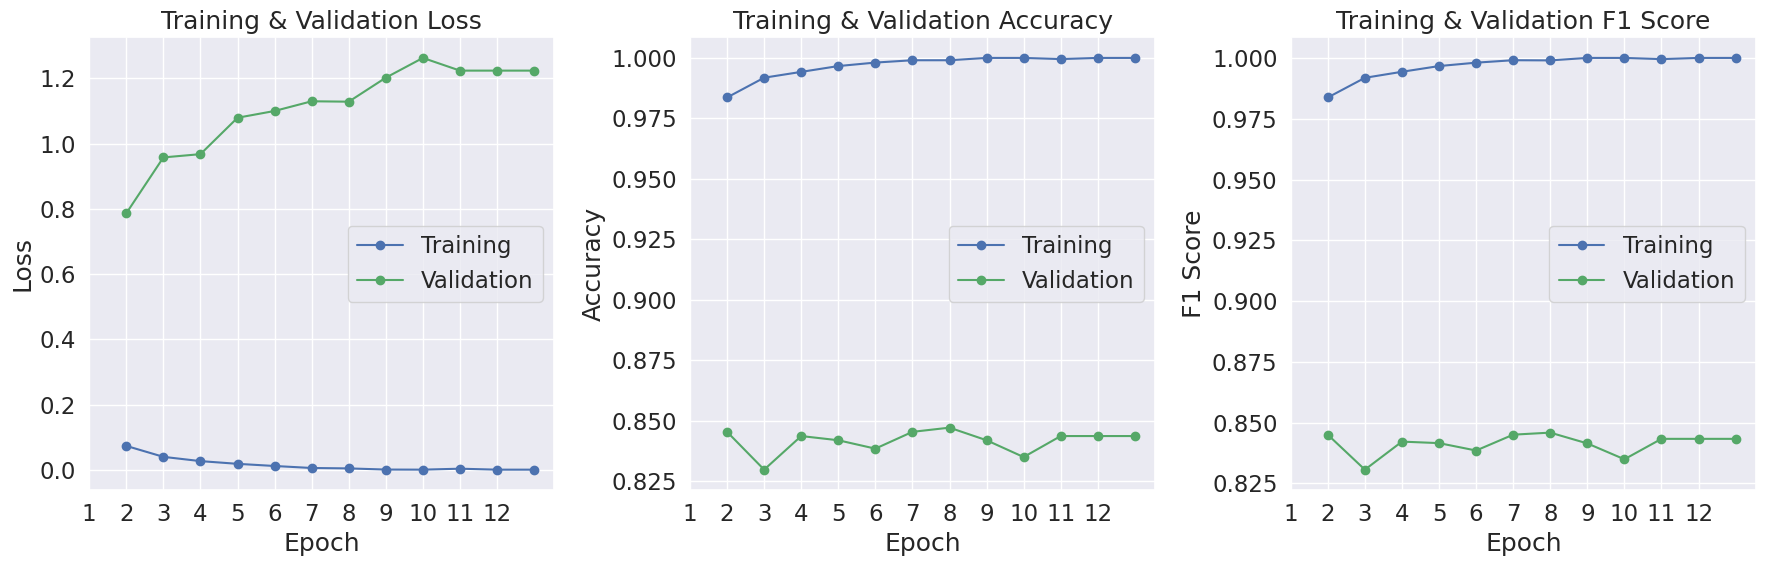

In [19]:
# Plot training and validation loss, accuracy, and F1

sns.set(style = 'darkgrid')
sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (18, 6)

fig, axes = plt.subplots(1, 3)

# loss
axes[0].plot(df_stats['Training loss'], 'b-o', label = "Training")
axes[0].plot(df_stats['Validation loss'], 'g-o', label = "Validation")
axes[0].set_title("Training & Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_xticks(range(len(df_stats['Training loss'])))
axes[0].set_xticklabels(range(1, len(df_stats['Training loss']) + 1))

# acc
axes[1].plot(df_stats['Training accuracy'], 'b-o', label = "Training")
axes[1].plot(df_stats['Validation accuracy'], 'g-o', label = "Validation")
axes[1].set_title("Training & Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_xticks(range(len(df_stats['Training accuracy'])))
axes[1].set_xticklabels(range(1, len(df_stats['Training accuracy']) + 1))

# F1 Score
axes[2].plot(df_stats['Training F1'], 'b-o', label = "Training")
axes[2].plot(df_stats['Validation F1'], 'g-o', label = "Validation")
axes[2].set_title("Training & Validation F1 Score")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("F1 Score")
axes[2].legend()
axes[2].set_xticks(range(len(df_stats['Training F1'])))
axes[2].set_xticklabels(range(1, len(df_stats['Training F1']) + 1))

plt.tight_layout()
plt.show()

## Test

In [112]:
def load_data(file_path):

    df = pd.read_csv(file_path)
    df['Sentiment'] = df['Sentiment'].map({'pos': 1, 'neg': 0})
    
    df['text'] = df['text'].astype(str)
    text = df['text'].tolist()
    labels = df['Sentiment'].tolist()

    return text, labels

F_train_text, F_train_labels = load_data("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/data_2/all_female_test.csv")
M_train_text, M_train_labels = load_data("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/data_2/all_male_test.csv")

# make sure its the right format
print(type(F_train_text))  #  <class 'list'>
print(len(F_train_text))  # 814
print(type(F_train_text[0])) # str

<class 'list'>
814
<class 'str'>


In [113]:
# Load  tokenizer

tokenizer = AutoTokenizer.from_pretrained("vesteinn/DanskBERT")

#finetuned_model= "/work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models/BERT_finetuned_original"
#tokenizer = AutoTokenizer.from_pretrained(finetuned_model)

tokenizer

XLMRobertaTokenizerFast(name_or_path='vesteinn/DanskBERT', vocab_size=50005, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50004: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [114]:
def tokenize_data(test_text, tokenizer):

    input_ids = []
    attention_masks = []

    for text in test_text:
        encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = 512,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt",
    )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim = 0)
    attention_masks = torch.cat(attention_masks, dim = 0)
    
    return input_ids, attention_masks

# Tokenize the female and male datasets
F_input_ids, F_attention_masks = tokenize_data(F_train_text, tokenizer)
M_input_ids, M_attention_masks = tokenize_data(M_train_text, tokenizer)

# Convert labels to tensors
F_labels = torch.tensor(F_train_labels)
M_labels = torch.tensor(M_train_labels)

# Verify shapes
print(F_input_ids.shape)  # [814, 512]
print(F_attention_masks.shape)  # [814, 512]
print(F_labels.shape)  # [814]

torch.Size([814, 512])
torch.Size([814, 512])
torch.Size([814])


In [115]:
# Create dataset
F_dataset = TensorDataset(F_input_ids, F_attention_masks, F_labels)
M_dataset = TensorDataset(M_input_ids, M_attention_masks, M_labels)

batch_size = 16  # 8, 16

F_dataloader = DataLoader(F_dataset, batch_size = batch_size, shuffle = True)
M_dataloader = DataLoader(M_dataset, batch_size = batch_size, shuffle = True)

In [116]:
# Load pretrained or fine-tuned  BERT

pretrained_model = AutoModelForSequenceClassification.from_pretrained("vesteinn/DanskBERT", num_labels = 2)
pretrained_model.to(device)

#finetuned_model = "/work/SofieNørboMosegaard#5741/NLP/NLP-exam/finetuned_models" # BERT_finetuned_original
#finetuned_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model)
#finetuned_model.to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at vesteinn/DanskBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(50005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=7

In [117]:
def test_model(model, dataloader):

    model.eval()

    predictions = []
    true_labels = []

    for batch in dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask = b_input_mask)
            logits = outputs.logits

        # Convert logits to predicted class labels
        preds = torch.argmax(logits, dim = 1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    return metrics, predictions

In [125]:
F_metrics, F_predictions = test_model(pretrained_model, F_dataloader)
F_metrics

{'accuracy': 0.49017199017199015,
 'precision': 0.4887459807073955,
 'recall': 0.37254901960784315,
 'f1_score': 0.4228094575799722}

In [126]:
M_metrics, M_predictions = test_model(pretrained_model, M_dataloader)
M_metrics

{'accuracy': 0.5,
 'precision': 0.5006180469715699,
 'recall': 0.9926470588235294,
 'f1_score': 0.6655710764174199}

In [120]:
def calculate_bias(female_preds, male_preds):

    bias = np.mean(np.array(female_preds) - np.array(male_preds))

    return bias

pretrained_bias = calculate_bias(F_predictions, M_predictions)
print(f"Pretrained model bias (Male - Female): {pretrained_bias}")

Pretrained model bias (Male - Female): -0.6117936117936118


In [147]:
# save results

metrics_female = {'Model': "Pretrained Model (Female Dataset)",
                'Metrics': F_metrics,
                'Bias': pretrained_bias}

metrics_male = {'Model': "Pretrained Model (Male Dataset)",
                'Metrics': M_metrics,
                'Bias': pretrained_bias}

predictions_female = {'Model': "Pretrained Model (Female Dataset)",
                    'Predictions': F_predictions,
                    'True_Labels': F_train_labels}

predictions_male = {'Model': "Pretrained Model (Male Dataset)",
                    'Predictions': M_predictions,
                    'True_Labels': M_train_labels}

# Save the metrics to a pickle file
with open("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/results/model_results.pkl", 'ab') as f:
    pickle.dump(metrics_female, f)
    pickle.dump(metrics_male, f)

# Save the predictions to a pickle file
with open("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/results/predictions.pkl", 'ab') as f:
    pickle.dump(predictions_female, f)
    pickle.dump(predictions_male, f)


In [152]:
with open("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/results/model_results.pkl", 'rb') as f:
    metrics_data = []
    metrics_data.append(pickle.load(f))

print(metrics_data)

with open("/work/SofieNørboMosegaard#5741/NLP/NLP-exam/results/predictions.pkl", 'rb') as f:
    predictions_data = []
    predictions_data.append(pickle.load(f))

print(predictions_data)


[{'Model': 'Pretrained Model (Female Dataset)', 'Metrics': {'accuracy': 0.49017199017199015, 'precision': 0.4887459807073955, 'recall': 0.37254901960784315, 'f1_score': 0.4228094575799722}, 'Bias': np.float64(-0.6117936117936118)}]
[{'Model': 'Pretrained Model (Female Dataset)', 'Predictions': [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np